# GitHub Ecosystem Mapping

In this notebook we will explore the Augur GitHub data to generate an ecosystem mapping of open source projects and communities by studying graphs based on relations such as common contributors and project activities between different GitHub repositories.

## Connect to Augur database

Until the Operate First enviroment can connect to the DB, use config file to access. Do not push config file to Github repo

In [1]:
import psycopg2
import pandas as pd 
import sqlalchemy as salc
import json
import os
import networkx as nx
import matplotlib.pyplot as plt

with open("../comm_cage.json") as config_file:
    config = json.load(config_file)

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

## Retrieve Available Respositories

In [3]:
aval_repos = pd.DataFrame()
repo_query = salc.sql.text(f"""
             SET SCHEMA 'augur_data';
             SELECT a.rg_name,
                a.repo_group_id,
                b.repo_name,
                b.repo_id,
                b.forked_from,
                b.repo_archived,
                b.repo_git
            FROM
                repo_groups a,
                repo b
            WHERE
                a.repo_group_id = b.repo_group_id
            ORDER BY
                rg_name,
                repo_name;
    """)
aval_repos = pd.read_sql(repo_query, con=engine)
display(aval_repos)
aval_repos.dtypes

,rg_name,repo_group_id,repo_name,repo_id,forked_from,repo_archived,repo_git
0,3scale,25556,3scale,33134,Parent not available,0.0,https://github.com/3scale/3scale.github.io
1,3scale,25556,3scale-amp-openshift-templates,33126,Parent not available,0.0,https://github.com/3scale/3scale-amp-openshift...
2,3scale,25556,3scale-api-python,33130,3scale-qe/3scale-api-python,0.0,https://github.com/3scale/3scale-api-python
3,3scale,25556,3scale-api-ruby,33158,Parent not available,0.0,https://github.com/3scale/3scale-api-ruby
4,3scale,25556,3scale-go-client,33169,Parent not available,0.0,https://github.com/3scale/3scale-go-client
...,...,...,...,...,...,...,...
10956,zerodayz,25482,sosreport-operator,30872,andreaskaris/sosreport-operator,0.0,https://github.com/zerodayz/sosreport-operator
10957,zerodayz,25482,talos,30863,siderolabs/talos,0.0,https://github.com/zerodayz/talos
10958,zerodayz,25482,tests,30838,kata-containers/tests,0.0,https://github.com/zerodayz/tests
10959,zerodayz,25482,web,30839,openshifttips/web,0.0,https://github.com/zerodayz/web


rg_name           object
repo_group_id      int64
repo_name         object
repo_id            int64
forked_from       object
repo_archived    float64
repo_git          object
dtype: object

## Retrieve Issue Contributors

We will now fetch all Issue contributors for various repositories.

In [4]:
issue_contrib = pd.DataFrame()
repo_query = salc.sql.text(f"""
            SET SCHEMA 'augur_data';
            SELECT r.repo_id,
            r.repo_git,
            i.cntrb_id
            FROM
            repo r, issues i
             WHERE
            i.repo_id = r.repo_id
            limit 50000
    """)
issue_contrib = pd.read_sql(repo_query, con=engine)
issue_contrib.columns =['Repo ID', 'Git', 'Issue Authors']

display(issue_contrib)
issue_contrib.dtypes

,Repo ID,Git,Issue Authors
0,24441,https://github.com/operate-first/operate-first...,25438.0
1,24441,https://github.com/operate-first/operate-first...,25438.0
2,24441,https://github.com/operate-first/operate-first...,25438.0
3,24441,https://github.com/operate-first/operate-first...,25438.0
4,24441,https://github.com/operate-first/operate-first...,25449.0
...,...,...,...
49995,25759,https://github.com/eclipse/lemminx,NaN
49996,25759,https://github.com/eclipse/lemminx,NaN
49997,25759,https://github.com/eclipse/lemminx,NaN
49998,25759,https://github.com/eclipse/lemminx,NaN


Repo ID            int64
Git               object
Issue Authors    float64
dtype: object

In [5]:
issue_contrib.nunique()

Repo ID          216
Git              216
Issue Authors    918
dtype: int64

## Retrieve PR Contributors

We will now fetch all the PR contributors for various repositories.

In [6]:
pr_contrib = pd.DataFrame()
repo_query = salc.sql.text(f"""
            SET SCHEMA 'augur_data';
            SELECT r.repo_id,
            r.repo_git,
            prm.cntrb_id
            FROM
            repo r, pull_request_meta prm 
             WHERE
            prm.repo_id = r.repo_id
            limit 50000
    """)
pr_contrib = pd.read_sql(repo_query, con=engine)
pr_contrib.columns =['Repo ID', 'Git', 'PR Creators']

display(pr_contrib)
pr_contrib.dtypes

,Repo ID,Git,PR Creators
0,27458,https://github.com/operate-first/continuous-de...,25443
1,27458,https://github.com/operate-first/continuous-de...,25465
2,27458,https://github.com/operate-first/continuous-de...,25444
3,27458,https://github.com/operate-first/continuous-de...,25465
4,27458,https://github.com/operate-first/continuous-de...,25433
...,...,...,...
49995,28335,https://github.com/ansible/ansible-modules-core,91339
49996,28335,https://github.com/ansible/ansible-modules-core,58062
49997,32524,https://github.com/openshift/test-pull-requests,2204263
49998,32524,https://github.com/openshift/test-pull-requests,2204295


Repo ID         int64
Git            object
PR Creators     int64
dtype: object

In [7]:
pr_contrib.nunique()

Repo ID         284
Git             284
PR Creators    2054
dtype: int64

## Retrieve PR Reviewers

We will now fetch all the PR Reviewers for various repositories.

Note:
- fetch PR id

In [8]:
prr_contrib = pd.DataFrame()
repo_query = salc.sql.text(f"""
            SET SCHEMA 'augur_data';
            SELECT r.repo_id,
            r.repo_git,
            prr.cntrb_id
            FROM
            repo r, pull_request_reviews prr
             WHERE
            prr.repo_id = r.repo_id
            limit 50000
    """)
prr_contrib = pd.read_sql(repo_query, con=engine)
prr_contrib.columns =['Repo ID', 'Git', 'PR Reviewers']

display(prr_contrib)
prr_contrib.dtypes

,Repo ID,Git,PR Reviewers
0,27458,https://github.com/operate-first/continuous-de...,25443
1,27458,https://github.com/operate-first/continuous-de...,25443
2,27458,https://github.com/operate-first/continuous-de...,25444
3,27458,https://github.com/operate-first/continuous-de...,25444
4,27458,https://github.com/operate-first/continuous-de...,25446
...,...,...,...
26800,28308,https://github.com/ansible/lightbulb,58328
26801,28308,https://github.com/ansible/lightbulb,58179
26802,28308,https://github.com/ansible/lightbulb,58059
26803,28308,https://github.com/ansible/lightbulb,58232


Repo ID          int64
Git             object
PR Reviewers     int64
dtype: object

In [9]:
prr_contrib.nunique()

Repo ID         191
Git             191
PR Reviewers    961
dtype: int64

## Retrieve Commit Contributors

We will now fetch all the Commit contributors for various repositories.

In [10]:
commit_contrib = pd.DataFrame()
repo_query = salc.sql.text(f"""
            SET SCHEMA 'augur_data';
            SELECT r.repo_id,
            r.repo_git,
            ca.cntrb_id
            FROM
            repo r, commits c, contributors_aliases ca
             WHERE
            c.repo_id = r.repo_id and
            c.cmt_committer_email = ca.alias_email
            limit 50000
    """)
commit_contrib = pd.read_sql(repo_query, con=engine)
commit_contrib.columns =['Repo ID', 'Git', 'Commit Creators']

display(commit_contrib)
commit_contrib.dtypes

,Repo ID,Git,Commit Creators
0,27572,https://github.com/SELinuxProject/selinux-kernel,32680
1,27572,https://github.com/SELinuxProject/selinux-kernel,32680
2,27572,https://github.com/SELinuxProject/selinux-kernel,32680
3,36109,https://github.com/torvalds/linux,32680
4,27572,https://github.com/SELinuxProject/selinux-kernel,32680
...,...,...,...
49995,36109,https://github.com/torvalds/linux,30918
49996,36109,https://github.com/torvalds/linux,29297
49997,36109,https://github.com/torvalds/linux,30918
49998,36109,https://github.com/torvalds/linux,30918


Repo ID             int64
Git                object
Commit Creators     int64
dtype: object

In [11]:
commit_contrib.nunique()

Repo ID            77
Git                77
Commit Creators    42
dtype: int64

## Merge Data Sets

We will now merge all the data sets into a single data frame.

In [12]:
df_all_new = pd.merge(commit_contrib, issue_contrib, on=['Repo ID','Git'], how='outer')

In [13]:
df_all_new.nunique()

Repo ID            293
Git                293
Commit Creators     42
Issue Authors      918
dtype: int64

In [14]:
df_all_new = pd.merge(df_all_new, pr_contrib, on=['Repo ID', 'Git'], how='outer')

In [15]:
df_all_new.nunique()

Repo ID             570
Git                 570
Commit Creators      42
Issue Authors       918
PR Creators        2054
dtype: int64

In [16]:
df_all_new = pd.merge(df_all_new, prr_contrib, on=['Repo ID', 'Git'], how='outer')

In [17]:
df_all_new.nunique()

Repo ID             570
Git                 570
Commit Creators      42
Issue Authors       918
PR Creators        2054
PR Reviewers        961
dtype: int64

In [18]:
df_all_new.head()

,Repo ID,Git,Commit Creators,Issue Authors,PR Creators,PR Reviewers
0,27572,https://github.com/SELinuxProject/selinux-kernel,32680.0,NaN,NaN,NaN
1,27572,https://github.com/SELinuxProject/selinux-kernel,32680.0,NaN,NaN,NaN
2,27572,https://github.com/SELinuxProject/selinux-kernel,32680.0,NaN,NaN,NaN
3,27572,https://github.com/SELinuxProject/selinux-kernel,32680.0,NaN,NaN,NaN
4,27572,https://github.com/SELinuxProject/selinux-kernel,32680.0,NaN,NaN,NaN


In [19]:
len(df_all_new)

100690528

In [20]:
# Lets subset the first 50000 rows
df_all = df_all_new[0:50000]

### Commit Contributor Graph

In [58]:
df_test = df_all.groupby(['Repo ID', 'Commit Creators', 'Issue Authors', 'PR Creators', 'PR Reviewers']).size().unstack(fill_value=0)

In [59]:
df_test.head()

,,,PR Reviewers
Repo ID,Commit Creators,Issue Authors,PR Creators


In [23]:
df_commit = df_all.groupby(['Repo ID', 'Commit Creators']).size().unstack(fill_value=0)
df_commit.head()

Commit Creators,29297.0,30918.0,32680.0
Repo ID,,,
27572,36,3909,3906
36109,0,0,42149


In [24]:
df_commit.columns

Float64Index([29297.0, 30918.0, 32680.0], dtype='float64', name='Commit Creators')

In [25]:
df_commit = df_commit.reset_index()

In [26]:
df_commit.head()

Commit Creators,Repo ID,29297.0,30918.0,32680.0
0,27572,36,3909,3906
1,36109,0,0,42149


In [27]:
df_melted_commit = df_commit.melt(
    ['Repo ID'],
    var_name = 'Contributor',value_name='number')

In [28]:
df_melted_commit.head()

,Repo ID,Contributor,number
0,27572,29297.0,36
1,36109,29297.0,0
2,27572,30918.0,3909
3,36109,30918.0,0
4,27572,32680.0,3906


In [29]:
Repo_id = df_melted_commit['Repo ID'].to_list()
len(Repo_id)

6

In [30]:
contributor_id = df_melted_commit['Contributor'].to_list()
len(contributor_id)

6

In [31]:
G = nx.from_pandas_edgelist(df_melted_commit, 
                            source='Repo ID',
                            target='Contributor',
                            edge_attr='number',
                            create_using=nx.MultiGraph())

In [32]:
nodes = G.nodes()
nodes

NodeView((27572, 29297.0, 36109, 30918.0, 32680.0))

In [33]:
nodes = list(nodes)
len(nodes)

5

In [34]:
colors = ['blue' if n in Repo_id else 'yellow' for n in nodes]

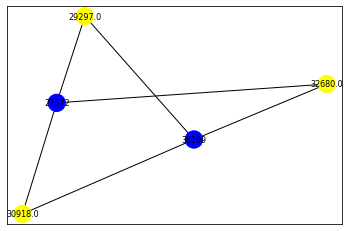

In [37]:
#fig = plt.figure(3, figsize=(500,500))
nx.draw_networkx(G, node_color=colors, font_size=8)

In [36]:
print(nx.info(G))

Name: 
Type: MultiGraph
Number of nodes: 5
Number of edges: 6
Average degree:   2.4000


### Issue Contributor Graph

In [60]:
df_issue = df_all.groupby(['Repo ID', 'Issue Authors']).size().unstack(fill_value=0)
df_issue.head()

Issue Authors
Repo ID


In [39]:
df_issue.columns

Float64Index([], dtype='float64', name='Issue Authors')

In [56]:
df_issue = df_issue.reset_index()

In [57]:
df_issue.head()

Issue Authors,Repo ID


In [ ]:
df_melted_issue = df_issue.melt(
    ['Repo ID'],
    var_name = 'Contributor',value_name='number')

In [ ]:
df_melted_issue.head()

In [ ]:
Repo_id = df_melted_issue['Repo ID'].to_list()
len(Repo_id)

In [ ]:
contributor_id = df_melted_issue['Contributor'].to_list()
len(contributor_id)

In [ ]:
G = nx.from_pandas_edgelist(df_melted_issue, 
                            source='Repo ID',
                            target='Contributor',
                            edge_attr='number',
                            create_using=nx.MultiGraph())

In [ ]:
nodes = G.nodes()
nodes

In [ ]:
nodes = list(nodes)
len(nodes)

In [ ]:
colors = ['blue' if n in Repo_id else 'yellow' for n in nodes]

In [ ]:
fig = plt.figure(3, figsize=(500,500))
nx.draw_networkx(G, node_color=colors, font_size=8)

In [ ]:
print(nx.info(G))

### PR Contributor Graph

In [40]:
df_pr = df_all.groupby(['Repo ID', 'PR Creators']).size().unstack(fill_value=0)
df_pr.head()

PR Creators,25650.0,27010.0,30165.0,40325.0,40326.0,40327.0,40328.0,40329.0,40330.0,40331.0
Repo ID,,,,,,,,,,
36109,20862,1647,2196,4268,2196,2196,2196,2196,2196,2196


In [41]:
df_pr = df_pr.reset_index()

In [42]:
df_melted_pr = df_pr.melt(
    ['Repo ID'],
    var_name = 'Contributor',value_name='number')

In [43]:
G = nx.from_pandas_edgelist(df_melted_pr, 
                            source='Repo ID',
                            target='Contributor',
                            edge_attr='number',
                            create_using=nx.MultiGraph())

In [46]:
nodes = G.nodes()

In [47]:
colors = ['blue' if n in Repo_id else 'yellow' for n in nodes]

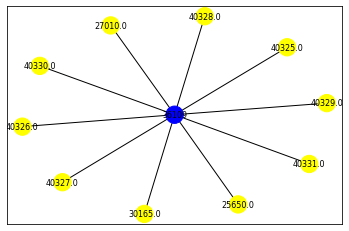

In [48]:
nx.draw_networkx(G, node_color=colors, font_size=8)

### PR Reviewers Graph

In [49]:
df_prr = df_all.groupby(['Repo ID', 'PR Reviewers']).size().unstack(fill_value=0)
df_prr.head()

PR Reviewers,27041.0,27211.0,27344.0,27821.0,29714.0,30475.0,31107.0,31197.0,36688.0,37958.0,...,43325.0,43326.0,43327.0,43328.0,43329.0,43330.0,43331.0,43332.0,43333.0,43335.0
Repo ID,,,,,,,,,,,,,,,,,,,,,
36109,77,154,77,77,77,154,308,77,77,77,...,76,76,76,152,76,76,76,76,76,76


In [50]:
df_prr = df_prr.reset_index()

In [51]:
df_melted_prr = df_prr.melt(
    ['Repo ID'],
    var_name = 'Contributor',value_name='number')

In [52]:
G = nx.from_pandas_edgelist(df_melted_prr, 
                            source='Repo ID',
                            target='Contributor',
                            edge_attr='number',
                            create_using=nx.MultiGraph())

In [53]:
nodes = G.nodes()

In [54]:
colors = ['blue' if n in Repo_id else 'yellow' for n in nodes]

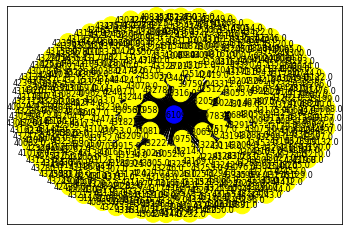

In [55]:
nx.draw_networkx(G, node_color=colors, font_size=8)